In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd
import scipy.signal
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
with h5py.File("../data/murray_rec_pfc.h5", "r") as h5f:
    train_inds = h5f["train_inds"][()]
    valid_inds = h5f["valid_inds"][()]

    def merge_train_valid(field):
        train_arr = h5f["train_" + field][()]
        valid_arr = h5f["valid_" + field][()]
        full_arr = np.empty((train_arr.shape[0] + valid_arr.shape[0],) + train_arr.shape[1:])
        full_arr[train_inds] = train_arr
        full_arr[valid_inds] = valid_arr
        return full_arr

    spikes = merge_train_valid("recon_data")
    rates = merge_train_valid("truth")
    inputs = merge_train_valid("true_stimulus")
    eff_inputs = merge_train_valid("eff_pfc_inputs")
    latents = merge_train_valid("latents")
    pop_rates = merge_train_valid("pop_rates")

In [3]:
trial_info = pd.read_csv("../data/murray_rec_pfc_trial_info.csv")

#### Just plotting the data

In [4]:
def plot_six_trials(arr):
    fig, axs = plt.subplots(2, 3, figsize=(10,3), sharey=True, sharex=True)
    for i in range(6):
        axs[i % 2][i // 2].plot(arr[i])
    plt.show()

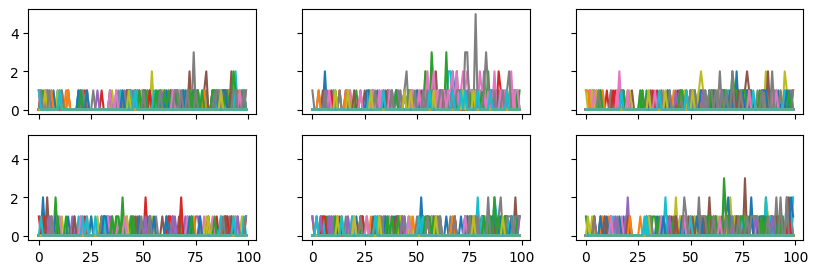

In [5]:
plot_six_trials(spikes)

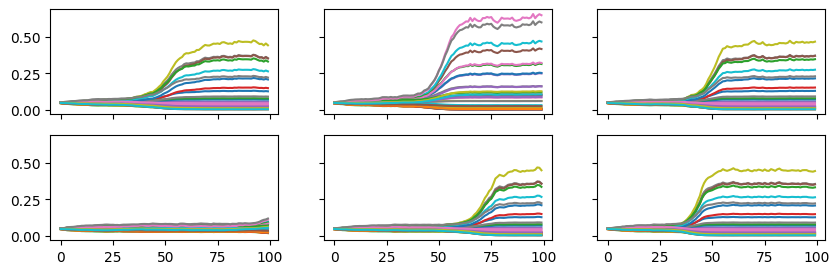

In [6]:
plot_six_trials(rates)

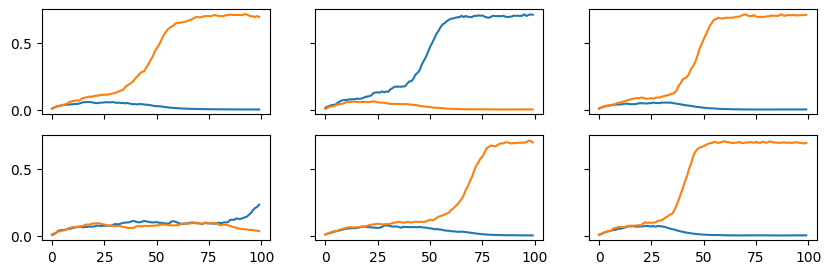

In [7]:
plot_six_trials(latents)

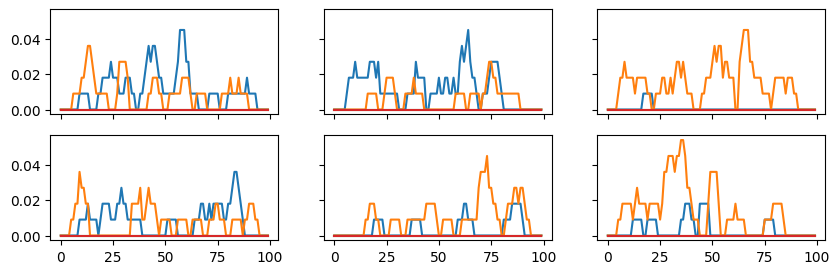

In [8]:
plot_six_trials(inputs)

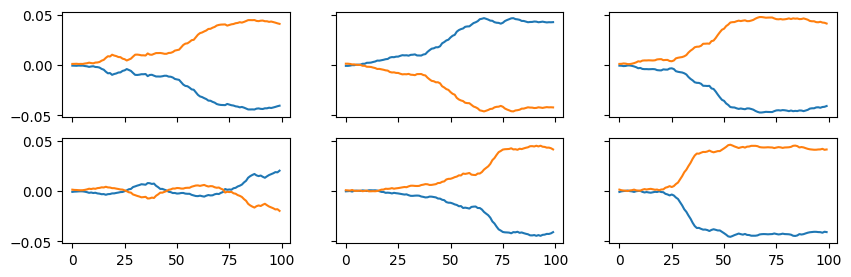

In [9]:
plot_six_trials(eff_inputs)

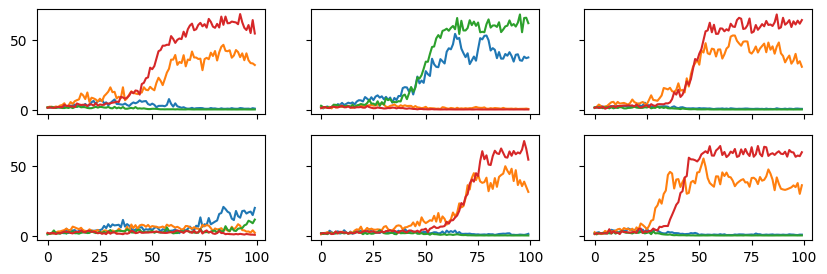

In [10]:
plot_six_trials(pop_rates)

#### Firing rate distribution

Text(0, 0.5, 'Count')

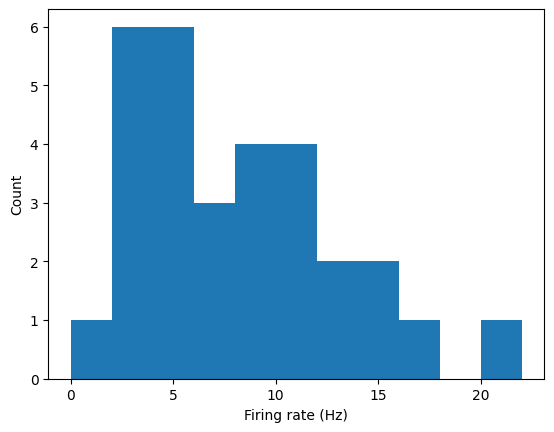

In [11]:
dt = 0.01
fr_dist = spikes.mean(axis=(0,1)) / dt

plt.hist(fr_dist, bins=np.arange(0, 24, 2))
plt.xlabel('Firing rate (Hz)')
plt.ylabel('Count')

Compared to prior experiences with spiking data, generally would say this has higher firing rates. Most real recordings heavily favor the 0-1 Hz bin and are strongly skewed right. This is skewed also but peaks somewhere in 2-6 Hz.

#### PSTHs

With smoothed spikes

In [12]:

def smooth_spikes(spikes, kern_sd=4):
    kernel = scipy.signal.windows.gaussian(M=kern_sd*6, std=kern_sd, sym=True)
    smoothed = np.apply_along_axis(
        func1d=lambda x: np.convolve(x, kernel, mode='same'),
        axis=1,
        arr=spikes,
    )
    return smoothed

smoothed = smooth_spikes(spikes, kern_sd=4)

In [13]:
def plot_six_neurons(arrs, labels=['left', 'right'], colors=['red', 'blue']):
    fig, axs = plt.subplots(2, 3, figsize=(10,3), sharex=True)
    for i in range(6):
        for j in range(len(arrs)):
            axs[i % 2][i // 2].plot(arrs[j][:, i], c=colors[j], label=labels[j])
    plt.show()

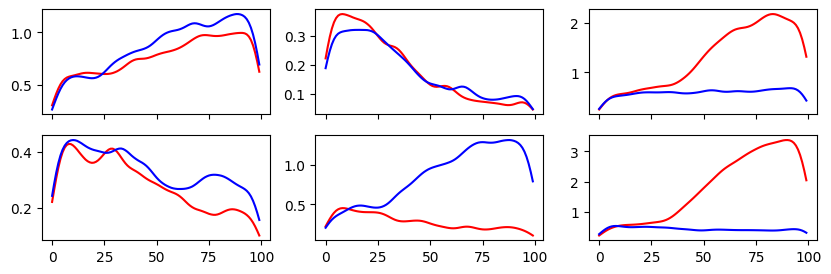

In [14]:
# first by correct target

left_trials = (trial_info.ground_truth == 0)
right_trials = (trial_info.ground_truth == 1)

arrs = [smoothed[left_trials].mean(axis=0), smoothed[right_trials].mean(axis=0)]
labels = ['left', 'right']
colors = ['red', 'blue']

plot_six_neurons(arrs, labels, colors)

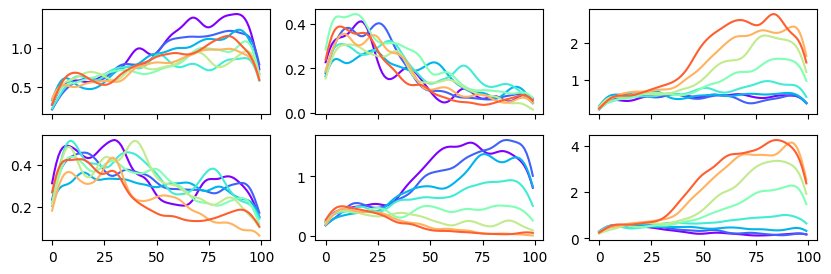

In [15]:
# then by coherence

cohs = sorted(trial_info.stim1_hz.unique().tolist())

colors = plt.cm.rainbow(np.arange(0, 1, 1/len(cohs)))
labels = cohs
arrs = [smoothed[trial_info.stim1_hz == coh].mean(axis=0) for coh in cohs]

plot_six_neurons(arrs, labels, colors)

So, some neurons are not super obviously tuned (from spike smoothing), and they display distinctly different timecourses - not all are ramping. So, pretty reasonable, I think. 

Looking at true rates:

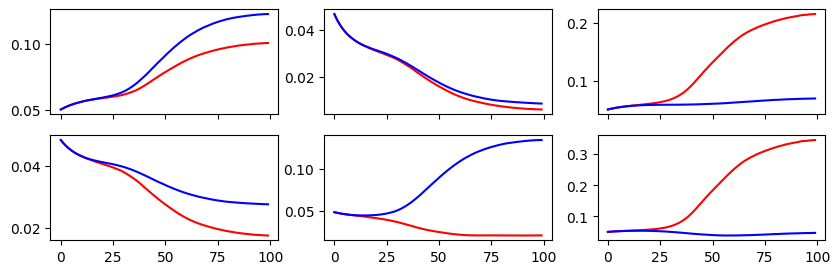

In [16]:
left_trials = (trial_info.ground_truth == 0)
right_trials = (trial_info.ground_truth == 1)

arrs = [rates[left_trials].mean(axis=0), rates[right_trials].mean(axis=0)]
labels = ['left', 'right']
colors = ['red', 'blue']

plot_six_neurons(arrs, labels, colors)

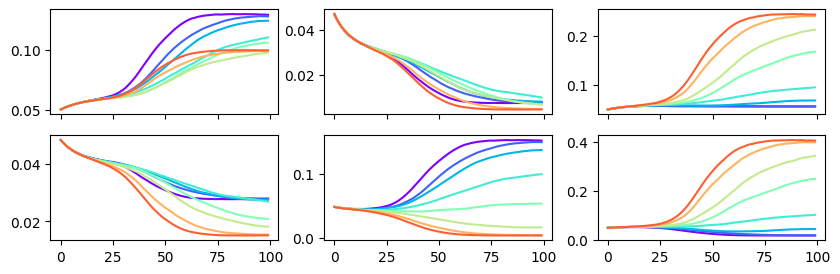

In [17]:
cohs = sorted(trial_info.stim1_hz.unique().tolist())

colors = plt.cm.rainbow(np.arange(0, 1, 1/len(cohs)))
labels = cohs
arrs = [rates[trial_info.stim1_hz == coh].mean(axis=0) for coh in cohs]

plot_six_neurons(arrs, labels, colors)

We actually sort of see non-monotonic tuning, e.g. neuron 1 decreases from purple to greenish but then increases as coherence continues toward the other direction, though the eventual steady-state reached remains the same, it just gets there faster, which makes sense.

#### PCA

With smoothed spikes:

In [18]:
def plot_pca(arrs, labels, colors, dim=2):
    fig = plt.figure(figsize=(5,5))
    if dim == 3:
        ax = fig.add_subplot(111, projection='3d')
    else:
        ax = fig.add_subplot(111)
    for n, arr in enumerate(arrs):
        data_to_plot = [arr[:,i] for i in range(dim)]
        ax.plot(*data_to_plot, label=labels[n], c=colors[n])
    plt.show()

In [19]:
left_trials = (trial_info.ground_truth == 0)
right_trials = (trial_info.ground_truth == 1)

left_smoothed = smoothed[left_trials]
right_smoothed = smoothed[right_trials]

all_data = np.concatenate([left_smoothed.mean(axis=0), right_smoothed.mean(axis=0)], axis=0)
all_data = StandardScaler().fit_transform(all_data)
pca = PCA()
pca.fit(all_data)
transformed = pca.transform(all_data)

left_pca, right_pca = np.split(transformed, [left_smoothed.shape[1]])

print(np.cumsum(pca.explained_variance_ratio_))

[0.55473323 0.94923559 0.98327676 0.98847456 0.99238511 0.99419322
 0.99588768 0.99689631 0.9978066  0.99834759 0.99874216 0.99906609
 0.99930769 0.99947927 0.99961636 0.99972899 0.99978971 0.99984465
 0.99988374 0.99991727 0.99994103 0.99996239 0.99997441 0.9999845
 0.99998949 0.99999374 0.99999677 0.99999843 0.99999943 1.        ]


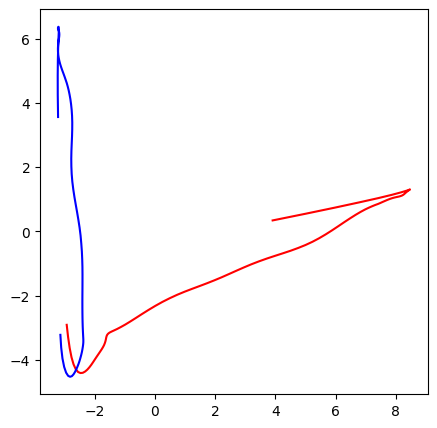

In [20]:
# plot 2d
plot_pca(
    arrs=[left_pca, right_pca], 
    labels=['left', 'right'],
    colors=['red', 'blue'],
    dim=2
)

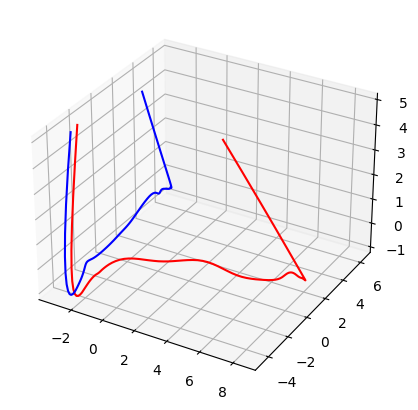

In [21]:
# plot 3d
plot_pca(
    arrs=[left_pca, right_pca], 
    labels=['left', 'right'],
    colors=['red', 'blue'],
    dim=3,
)

In [22]:
cohs = sorted(trial_info.stim1_hz.unique().tolist())

colors = plt.cm.rainbow(np.arange(0, 1, 1/len(cohs)))
labels = cohs
arrs = [smoothed[trial_info.stim1_hz == coh].mean(axis=0) for coh in cohs]

all_data = np.concatenate(arrs, axis=0)
all_data = StandardScaler().fit_transform(all_data)
pca = PCA()
pca.fit(all_data)
transformed = pca.transform(all_data)

arrs = np.split(transformed, np.cumsum([a.shape[0] for a in arrs])[:-1])

print(np.cumsum(pca.explained_variance_ratio_))

[0.54855428 0.91562916 0.94872106 0.95628463 0.9636909  0.96993564
 0.97521346 0.97926853 0.98324713 0.98615199 0.9884245  0.99047521
 0.99213086 0.99366762 0.99478966 0.99582194 0.99674551 0.9973053
 0.9978523  0.99830296 0.99865195 0.99893056 0.999155   0.99935828
 0.99953006 0.99965896 0.99976339 0.99985477 0.99994098 1.        ]


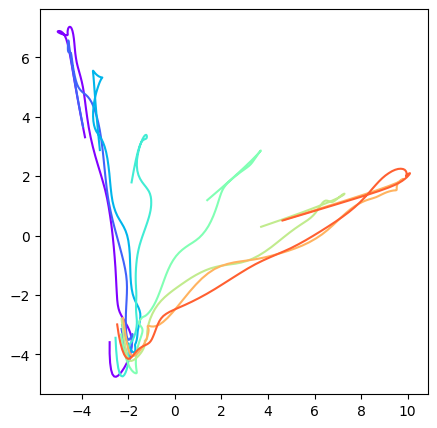

In [23]:
# plot 2d
plot_pca(
    arrs=arrs, 
    labels=labels,
    colors=colors,
    dim=2,
)

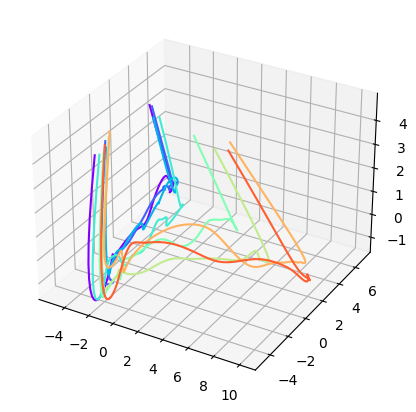

In [24]:
# plot 3d
plot_pca(
    arrs=arrs, 
    labels=labels,
    colors=colors,
    dim=3,
)

Quickly with rates:

In [25]:
cohs = sorted(trial_info.stim1_hz.unique().tolist())

colors = plt.cm.rainbow(np.arange(0, 1, 1/len(cohs)))
labels = cohs
arrs = [rates[trial_info.stim1_hz == coh].mean(axis=0) for coh in cohs]

all_data = np.concatenate(arrs, axis=0)
all_data = StandardScaler().fit_transform(all_data)
pca = PCA()
pca.fit(all_data)
transformed = pca.transform(all_data)

arrs = np.split(transformed, np.cumsum([a.shape[0] for a in arrs])[:-1])

print(np.cumsum(pca.explained_variance_ratio_))

[0.58129138 0.9896188  0.99852349 0.99996952 0.99999381 0.99999833
 0.99999976 0.99999991 0.99999999 1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.        ]


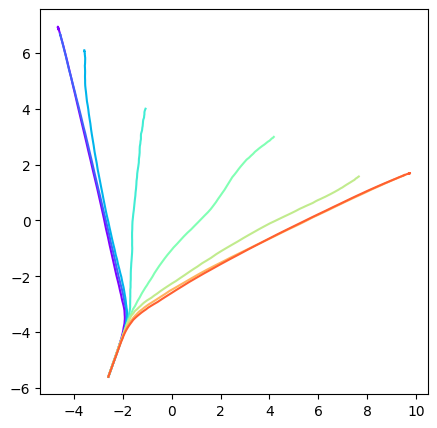

In [26]:
# plot 2d
plot_pca(
    arrs=arrs, 
    labels=labels,
    colors=colors,
    dim=2,
)

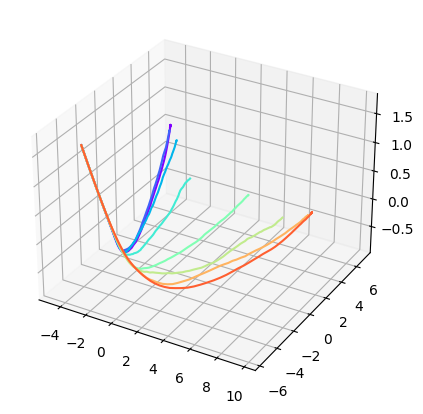

In [27]:
# plot 3d
plot_pca(
    arrs=arrs, 
    labels=labels,
    colors=colors,
    dim=3,
)

Seems like edge effects in the smoothed spikes plots are largely from the smoothing itself. Good to know. That last rate PCA plot is pretty.

#### Behavioral stuff

In [28]:
trial_outcome = (pop_rates[:,-1,3] - pop_rates[:,-1,2]) >= 0
correct = (trial_outcome == trial_info.ground_truth.to_numpy())

Text(0, 0.5, 'Percent choose to right')

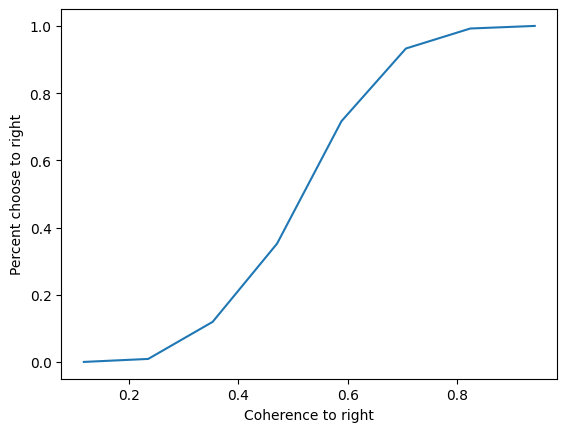

In [29]:
cohs = sorted(trial_info.stim2_hz.unique().tolist())
cohs_arr = np.sort(trial_info.stim2_hz.unique()) / 34

decisions = [trial_outcome[trial_info.stim2_hz == coh].mean() for coh in cohs]
plt.plot(cohs_arr, decisions)
plt.xlabel('Coherence to right')
plt.ylabel('Percent choose to right')

Text(0, 0.5, 'Accuracy')

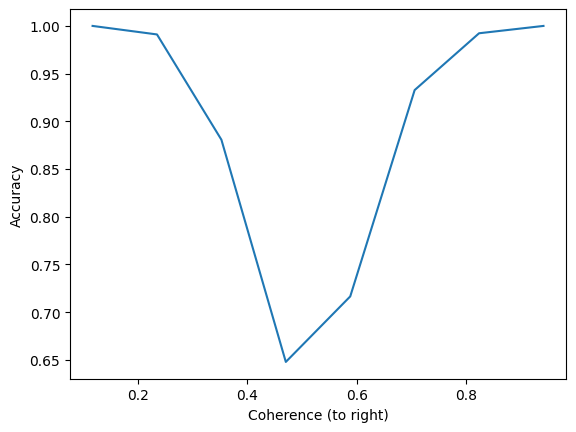

In [30]:
cohs = sorted(trial_info.stim2_hz.unique().tolist())
cohs_arr = np.sort(trial_info.stim2_hz.unique()) / 34

accuracy = [correct[trial_info.stim2_hz == coh].mean() for coh in cohs]
plt.plot(cohs_arr, accuracy)
plt.xlabel('Coherence (to right)')
plt.ylabel('Accuracy')

Generally seems okay. Was originally asymmetric though, somehow avoided by switching from normal IC distribution to exponential.

Text(0, 0.5, 'Reaction time')

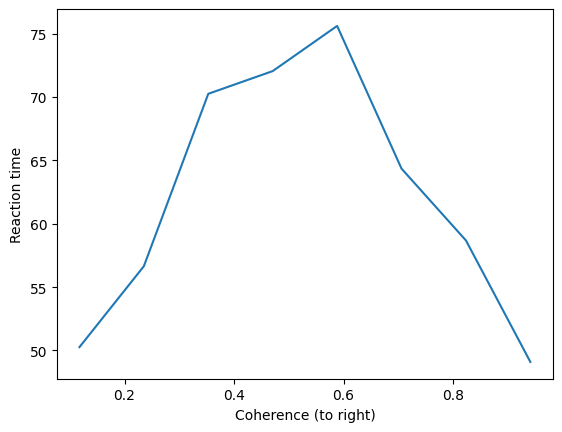

In [31]:
# reaction times

threshold = 50

decision_idx = np.array([np.nanmin(np.concatenate([np.nonzero(trial[:,2:] >= threshold)[0], np.array([105])])) for trial in pop_rates])

cohs = sorted(trial_info.stim2_hz.unique().tolist())
cohs_arr = np.sort(trial_info.stim2_hz.unique()) / 34

rt = [np.nanmean(decision_idx[trial_info.stim2_hz == coh]) for coh in cohs]
plt.plot(cohs_arr, rt)
plt.xlabel('Coherence (to right)')
plt.ylabel('Reaction time')

General trend seems correct.